# 1. Data Load


In [1]:
import numpy as np
import pandas as pd

from scipy import stats #Analysis 
from scipy.stats import norm # Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
#%matplotlib tk

#import matplotlib 
#matplotlib.font_manager._rebuild()

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_big.csv")

# original data -> data
data.head()

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price
0,201709,24432350113,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,21514
1,201709,13141330215,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,52264
2,201706,39421720107,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,42656
3,201706,4602500509,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,34561
4,201709,39313780106,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,38423


# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [4]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 201.0+ MB


# 3. Preprocessing
- missing value 제거 
    - monthly_gain : 3,605 제거 -> 149,790
    - shop_type_big : 4,303 제거 -> 145,487 
    - gender feature : 1,187 제거 -> 144,300
- shop_code, shop_name : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
    - 여기까지 총 144,300 X 27
- shop_type_big(13), shop_type_small(367) : label encodding
- longitude, latitude : clustering을 통해 labeling 후 해당 두 열은 drop 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는??

In [43]:
# 원본 data와 따로 관리 -> original data = data, input data = input_data 
# feature drop
input_data = data.copy()
input_data = input_data.drop(['date', 'shop_code', 'shop_name'], axis=1)

In [44]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = input_data[input_data['monthly_gain']==0].index 
print(len(null_index))
input_data = input_data.drop(null_index)

# missing value drop - shop_type_big
null_index = input_data[input_data['shop_type_big'].isnull()==True].index
input_data = input_data.drop(null_index)

# missing value drop - shop_type_small 
print(len(input_data['shop_type_small'].unique()))
print(input_data['shop_type_small'].isnull().value_counts())

0
61
False    2927739
Name: shop_type_small, dtype: int64


In [45]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data['shop_type_big'] = le.fit_transform(list(input_data['shop_type_big']))   # fit transform으로 한번에 처리 가능
#le.classes_

le = LabelEncoder()
input_data['shop_type_small'] = le.fit_transform(list(input_data['shop_type_small'])) 
#le.classes_

[[ 37.50145669 127.03453485]
 [ 37.49490506 126.89669306]
 [ 37.56615661 126.99453604]
 [ 37.53984087 126.84569152]
 [ 37.51707179 127.12106144]
 [ 37.49662706 126.95210674]
 [ 37.63922276 127.04500915]
 [ 37.57114291 127.06772668]
 [ 37.57394645 126.92464336]]
[3 4 1 ... 7 4 1]


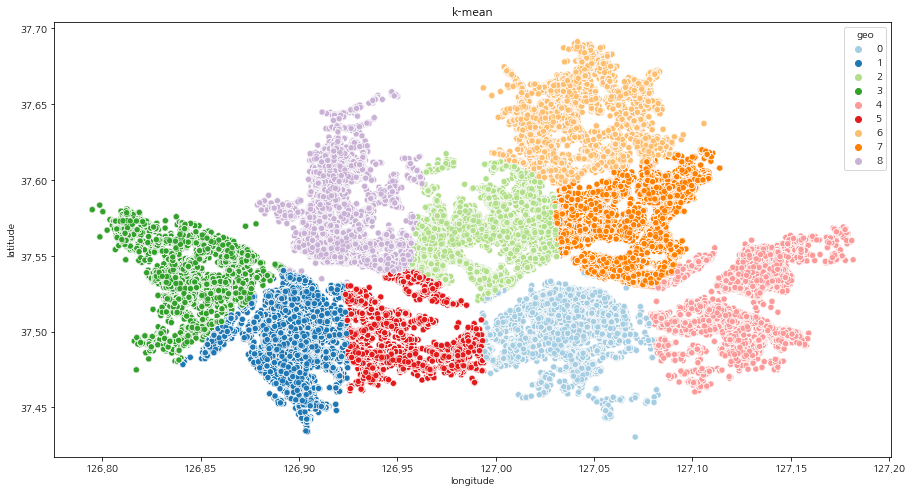

In [46]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(input_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

# longitude + latitude = geo 
# So we get inpute_data = 2,927,739 rows × 5 columns
input_data['geo'] = kmeans.labels_

sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=input_data, palette="Paired")
plt.title('k-mean')

input_data = input_data.drop(['longitude', 'latitude'], axis=1)

In [47]:
# average_sale_price -> skewed 된 feature 
# log정규화 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']

for _ in scale_cols : 
    scaled_data = pd.DataFrame(np.log1p(input_data[_]))
    input_data[_] = scaled_data

input_data

,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,3,0,12881013.37,9.98,3
1,3,0,33931612.72,10.86,4
2,3,0,21456513.16,10.66,1
3,3,0,6140707.30,10.45,4
4,3,0,6091482.50,10.56,5
...,...,...,...,...,...
2927734,6,60,13693767.90,9.98,5
2927735,6,60,17432801.29,11.22,7
2927736,6,60,17023101.74,10.44,7
2927737,6,60,31533908.77,10.88,4


<AxesSubplot:xlabel='shop_type_big', ylabel='average_sale_price'>

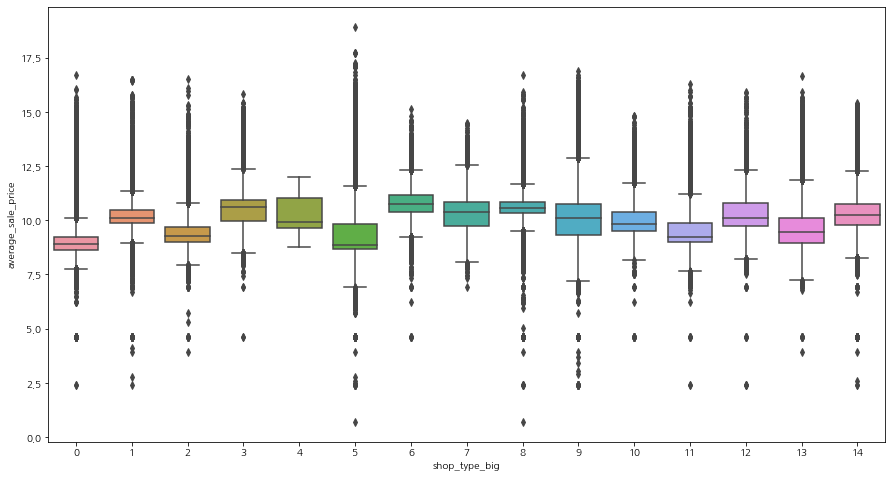

In [48]:
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='average_sale_price', data=input_data)

<AxesSubplot:xlabel='shop_type_big', ylabel='monthly_gain'>

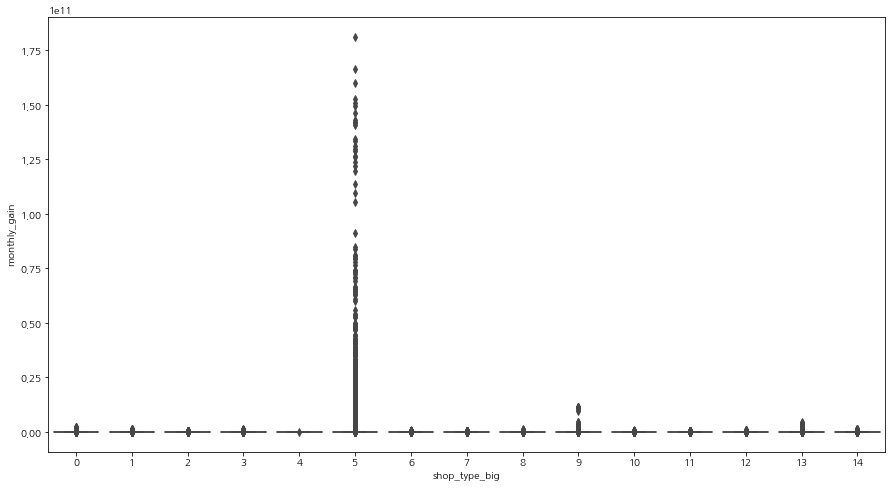

In [49]:
rcParams['figure.figsize'] = 15,8
sns.boxplot(x='shop_type_big', y='monthly_gain', data=input_data)

# 4. Target Variable Labeling
### 어떻게 라벨링 할 것인가?
- 원래 가격대에 대한 정보(price_dict)는 계속 가져가야 함! 
- **Label(10)**  min 10% 20% ... 80% 90% max의 값을 찾은 후, monthly_gain에 대해 두 범위 사이에 존재하는 값에 대해서 평균 값으로 라벨링 합니다. 
    - 예) min 과 10% 사이의 값 -> min과 10%의 평균 값으로 라벨링
    - 라벨링 분포가 정확히 14432~14430 사이로 떨어짐 -> 오로지 백분율로 잘랐기 때문에 분포에 대한 걱정은 안해도 됨
    - accuracy f-1score : 0.50 ~ 0.49
- **Label(3)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 33 ~ 66 ~ 99(100) -> 총 3개의 label 생성
    - 1: 3,669,015.0075000003, 2: 18,734,738.491500005, 3: 303,196,624.6690003
    - 3백, 2천(1천8백만), 3억
    - accuracy f-1score : 0.84 ~ 0.82
- **Label(4)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 25 ~ 50 ~ 75 ~ 100 -> 총 4개의 label 생성
    - 1: 2,324,858.25, 2: 10,317,593.25, 3: 29,815,219.125, 4: 32,692,544,860.4
    - 2백, 1천만, 3천만(2천9백), 326억
    - accuracy f-1score : 0.78 ~ 0.76
- **Label(5)**  위와 동일한 방식으로 자릅니다. 
    - 0 ~ 20 ~ 40 ~ 60 ~ 80 ~ 100 -> 총 5개의 label 생성
    - 1: 1,622,880.0, 2: 6,773,160.0, 3: 17,044,674.75,4: 39,214,985.75, 5: 32,698,042,967.275
    - 1백만, 6백만, 1천7백만, 4천(3천9백만), 326억
    - accuracy f-1score : 0.71 ~ 0.70
- 백분율로 자르는 방법
    - labe(10)의 경우 유난히 4~8 label에 대해서는 잘 못맞춤 -> monthly_gain을 일렬로 세웠을 때 앞 뒤로 뭉쳐있어서 그런 것 같음 
    - 무작정 quantity하게 값을 나눠서 라벨링 하는 것은 좋은 것 같지 않음..
    - 앞, 뒤로는 자잘하게 자르고 가운데는 큼직하게 잘라야..?
    - 확실히 class의 개수가 많아질수록 accuracy가 낮아짐

In [50]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

input_data.head()

,shop_type_big,shop_type_small,monthly_gain,average_sale_price,geo
0,3,0,12881013.37,9.98,3
1,3,0,33931612.72,10.86,4
2,3,0,21456513.16,10.66,1
3,3,0,6140707.30,10.45,4
4,3,0,6091482.50,10.56,5


[ 3 14  2  1  6 10 13 11 12  8  5  4  7  9  0]


<AxesSubplot:xlabel='shop_type_small'>

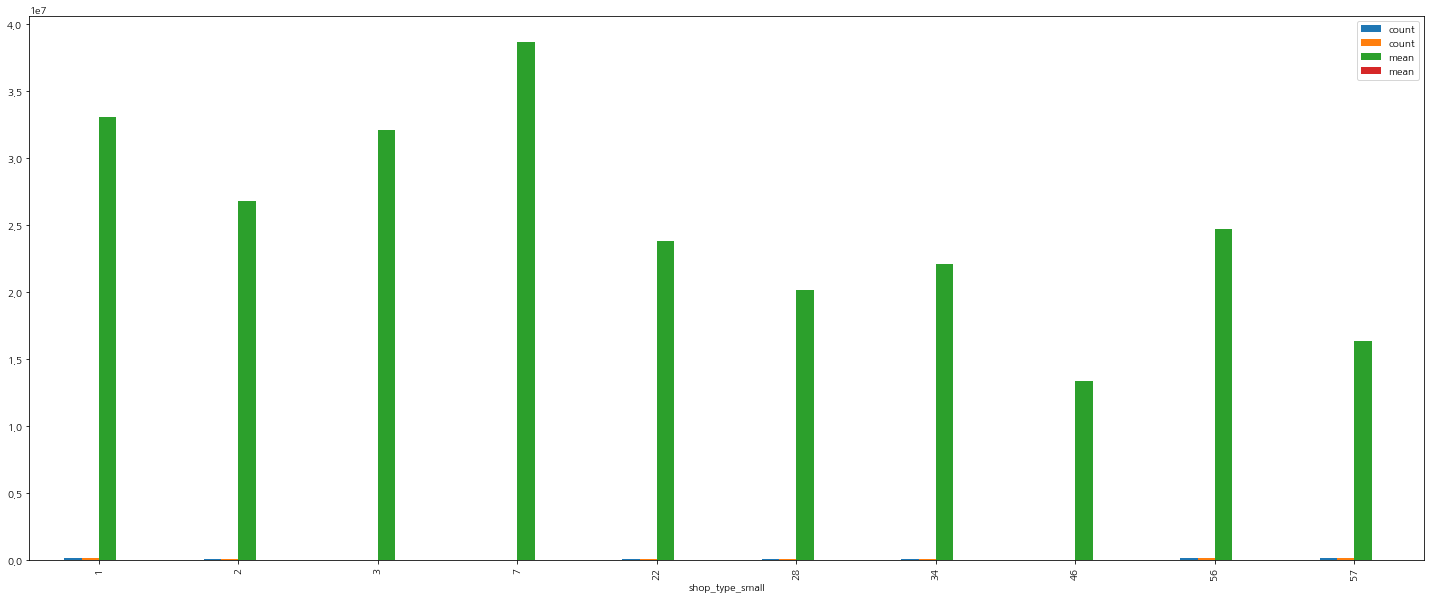

In [51]:
# shop_type_big 으로 묶은 후 shop_type_small 간의 평균 가격대를 비교하는 코드 
# 제조같은 분야는 하나의 소분야가 압도적으로 가격대가 높게 형성되어 있고 나머지는 비슷비슷함
# 스포츠 같은 경우는 모든 소분야가 비슷한 가격대를 형성함 
df_check = input_data[['monthly_gain', 'shop_type_small', 'shop_type_big']]
typebig_list = df_check['shop_type_big'].unique()
print(typebig_list)

df_typesmall = []
for _ in typebig_list :
    df = df_check[df_check['shop_type_big'] == _ ].groupby('shop_type_small').describe().droplevel(axis=1,level=0)
    df_typesmall.append(df)
df_typesmall[1].plot.bar(y=['count','mean'], figsize=(25,10))

#### Labeling 1) quantity하게, 백분율을 이용해서 

In [53]:
price_dict = {}  # original price를 저장하기 위한 dict
price_list = [0] # 시작 min 값은 0 
for i in range(1, 11) :# 1 2 3  
    price_list.append(input_data['monthly_gain'].quantile(q=i*0.1)) # 10% ~ 100% 값을 가져옵니다    

def labeling(x) : 
    for i in range(1, len(price_list)) :
        price_dict[i] = (price_list[i]+price_list[i-1])/2
        if x < price_list[i] and x >= price_list[i-1] : return i
    return i

print(price_dict)
input_data['monthly_gain'] = input_data.monthly_gain.apply(labeling)
input_data['monthly_gain'].unique()

{}


array([ 6,  9,  7,  4,  1, 10,  3,  5,  8,  2], dtype=int64)

In [54]:
print("Skewness: %f" % input_data['monthly_gain'].skew())
print("Kurtosis: %f" % input_data['monthly_gain'].kurt())

Skewness: -0.000000
Kurtosis: -1.224243


C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Monthly gain Histogram with Density Plot')

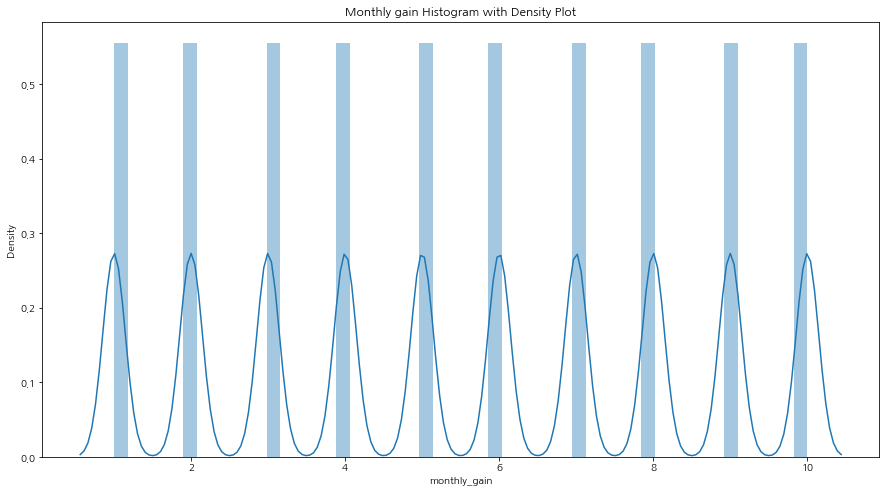

In [55]:
ax = plt.subplots()
ax = sns.distplot(input_data['monthly_gain'], hist = True)
ax.set_title('Monthly gain Histogram with Density Plot')

In [56]:
price_dict

{1: 766177.392,
 2: 2416853.102,
 3: 4367341.306000001,
 4: 6771578.880000001,
 5: 9842625.509,
 6: 13910004.138000002,
 7: 19613928.162,
 8: 28182833.791999996,
 9: 43187748.551,
 10: 90645164352.75299}

# 5. Modeling
- XGB
- LGBM
- MultiClass Classification 

In [57]:
input_data_y = input_data['monthly_gain'].copy()
input_data_X = input_data.drop(['monthly_gain'], axis=1)

In [58]:
from sklearn.model_selection import train_test_split, cross_validate, KFold, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
# train/ test data로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,
    shuffle=True,
    random_state=42,
    stratify=input_data_y # 분포, 모델성능에 굉장히 중요한 요소! Classification 문제에서는 필수!
)

# train / valid data로 split 
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X,
    tr_val_y, 
    test_size = 0.2, 
    shuffle=True,
    random_state=42,
    stratify=tr_val_y
)

In [60]:
print(train_y.value_counts())
print(test_y.value_counts())

8     187376
9     187376
3     187375
1     187375
10    187375
4     187375
7     187375
6     187375
5     187375
2     187375
Name: monthly_gain, dtype: int64
2     58555
8     58555
10    58555
1     58555
4     58555
3     58555
7     58555
6     58555
9     58554
5     58554
Name: monthly_gain, dtype: int64


In [61]:
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
model_xgb = XGBClassifier(
    eval_metric='mlogloss')
model_lgbm = LGBMClassifier(
    eval_metric='mlogloss')

In [62]:
model_xgb.fit(train_X, train_y, eval_set=[(valid_X, valid_y)])

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.25552
[1]	validation_0-mlogloss:2.22350
[2]	validation_0-mlogloss:2.20201
[3]	validation_0-mlogloss:2.18598
[4]	validation_0-mlogloss:2.17338
[5]	validation_0-mlogloss:2.16402
[6]	validation_0-mlogloss:2.15607
[7]	validation_0-mlogloss:2.14957
[8]	validation_0-mlogloss:2.14430
[9]	validation_0-mlogloss:2.13912
[10]	validation_0-mlogloss:2.13489
[11]	validation_0-mlogloss:2.13109
[12]	validation_0-mlogloss:2.12859
[13]	validation_0-mlogloss:2.12556
[14]	validation_0-mlogloss:2.12358
[15]	validation_0-mlogloss:2.12161
[16]	validation_0-mlogloss:2.11978
[17]	validation_0-mlogloss:2.11796
[18]	validation_0-mlogloss:2.11575
[19]	validation_0-mlogloss:2.11451
[20]	validation_0-mlogloss:2.11266
[21]	validation_0-mlogloss:2.11043
[22]	validation_0-mlogloss:2.10906
[23]	validation_0-mlogloss:2.10796
[24]	validation_0-mlogloss:2.10686
[25]	validation_0-mlogloss:2.10567
[26]	validation_0-mlogloss:2.10478
[27]	validation_0-mlogloss:2.10398
[28]	validation_0-mlogloss:2.1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
model_lgbm.fit(train_X, train_y, eval_set=[(valid_X, valid_y)])

[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	valid_0's multi_logloss: 2.27172
[2]	valid_0's multi_logloss: 2.24867
[3]	valid_0's multi_logloss: 2.23072
[4]	valid_0's multi_logloss: 2.21619
[5]	valid_0's multi_logloss: 2.20427
[6]	valid_0's multi_logloss: 2.19411
[7]	valid_0's multi_logloss: 2.18538
[8]	valid_0's multi_logloss: 2.17792
[9]	valid_0's multi_logloss: 2.17151
[10]	valid_0's multi_logloss: 2.16538
[11]	valid_0's multi_logloss: 2.16025
[12]	valid_0's multi_logloss: 2.15573
[13]	valid_0's multi_logloss: 2.15159
[14]	valid_0's multi_logloss: 2.14822
[15]	valid_0's multi_logloss: 2.1451
[16]	valid_0's multi_logloss: 2.14245
[17]	valid_0's multi_logloss: 2.1399
[18]	valid_0's multi_logloss: 2.1375
[19]	valid_0's multi_logloss: 2.13549
[20]	valid_0's multi_logloss: 2.13346
[21]	valid_0's multi_logloss: 2.13169
[22]	valid_0's multi_logloss: 2.1301
[23]	valid_0's multi_logloss: 2.12835
[24]	valid_0's multi_logloss: 2.12692
[25]	valid_0's multi_logloss: 2.12547
[26]	valid_

LGBMClassifier(eval_metric='mlogloss')

In [64]:
pred_xgb = model_xgb.predict(test_X)
pred_lgbm = model_lgbm.predict(test_X)

# 6. Evaluation

In [65]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균  

In [66]:
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           1       0.30      0.55      0.38     58555
           2       0.17      0.24      0.20     58555
           3       0.16      0.12      0.14     58555
           4       0.15      0.11      0.13     58555
           5       0.15      0.08      0.10     58554
           6       0.16      0.10      0.13     58555
           7       0.15      0.12      0.13     58555
           8       0.17      0.10      0.13     58555
           9       0.27      0.34      0.30     58554
          10       0.31      0.46      0.37     58555

    accuracy                           0.22    585548
   macro avg       0.20      0.22      0.20    585548
weighted avg       0.20      0.22      0.20    585548



In [67]:
print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           1       0.24      0.52      0.33     58555
           2       0.17      0.22      0.19     58555
           3       0.15      0.12      0.13     58555
           4       0.15      0.09      0.12     58555
           5       0.16      0.09      0.12     58554
           6       0.17      0.08      0.11     58555
           7       0.15      0.11      0.12     58555
           8       0.16      0.09      0.12     58555
           9       0.27      0.33      0.30     58554
          10       0.29      0.46      0.36     58555

    accuracy                           0.21    585548
   macro avg       0.19      0.21      0.19    585548
weighted avg       0.19      0.21      0.19    585548



In [68]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,9,8
1,2,4
2,9,9
3,9,9
4,8,3
...,...,...
585543,6,6
585544,7,6
585545,3,1
585546,7,10


In [69]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,9,8
1,2,4
2,9,7
3,9,9
4,8,3
...,...,...
585543,6,6
585544,7,7
585545,3,2
585546,7,7


C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


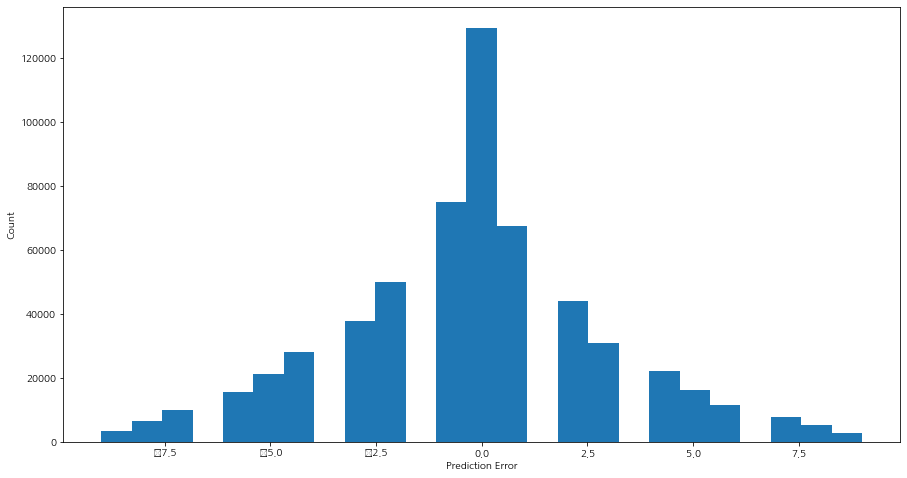

In [70]:
show_prediction_error(test_y, pred_xgb)

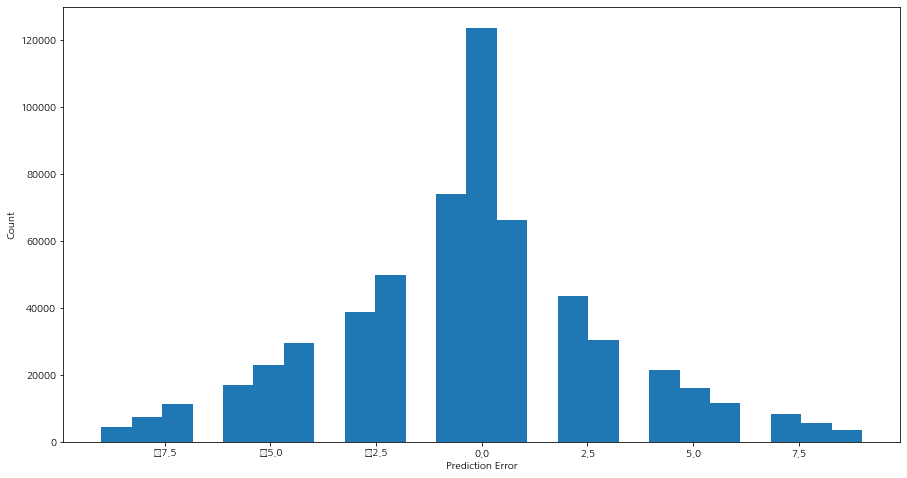

In [71]:
show_prediction_error(test_y, pred_lgbm)

<AxesSubplot:>

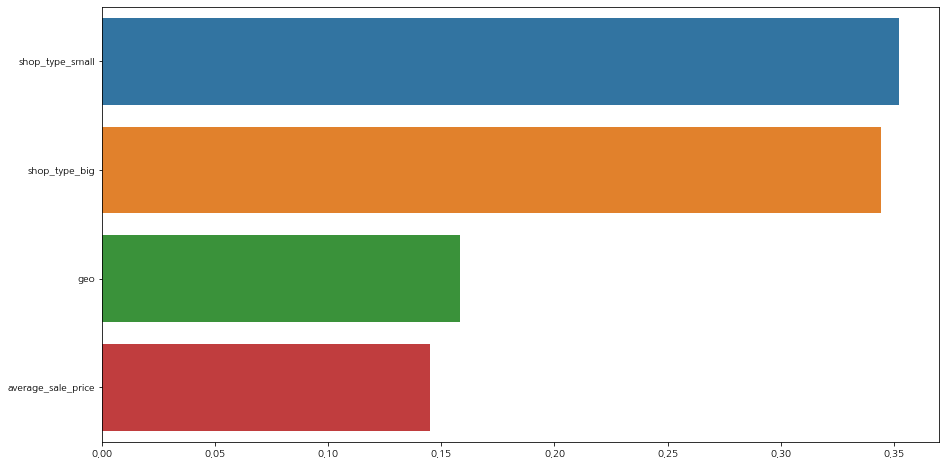

In [72]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

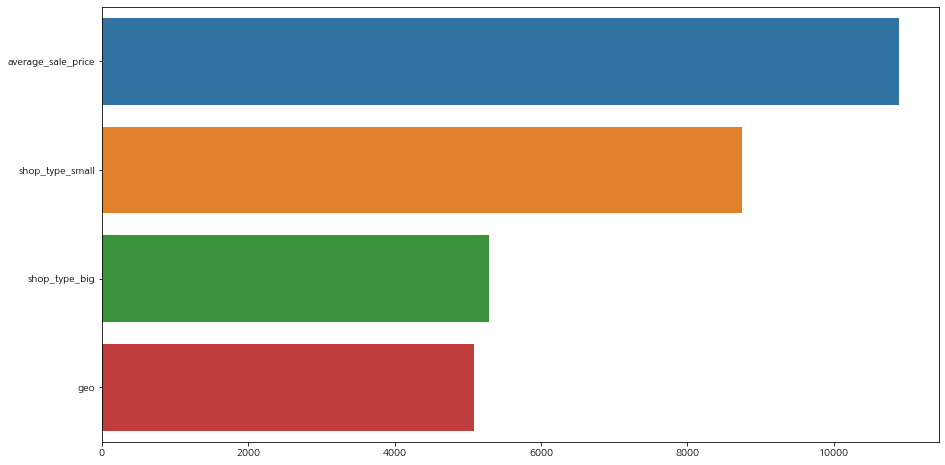

In [73]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)